In [ ]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Import your preprocessing functions
from preprocessing import preprocess_keypoints  # Import preprocess_keypoints function

RANDOM_SEED = 42
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
NUM_CLASSES = 3

# Load dataset
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

# Apply preprocessing with smoothing filter
X_smoothing = preprocess_keypoints(X_dataset, filter_type='smoothing', normalize=True)
y_dataset_smoothing = y_dataset[:X_smoothing.shape[0]]  # Ensure the lengths match

# Apply preprocessing with Gaussian filter
X_gaussian = preprocess_keypoints(X_dataset, filter_type='gaussian', normalize=True)
y_dataset_gaussian = y_dataset[:X_gaussian.shape[0]]  # Ensure the lengths match

# Apply preprocessing with Kalman filter
X_kalman = preprocess_keypoints(X_dataset, filter_type='kalman', normalize=True)
y_dataset_kalman = y_dataset[:X_kalman.shape[0]]  # Ensure the lengths match

# Train-test split for smoothing filter
X_train_smoothing, X_test_smoothing, y_train_smoothing, y_test_smoothing = train_test_split(
    X_smoothing, y_dataset_smoothing, train_size=0.75, random_state=RANDOM_SEED
)

# Train-test split for Gaussian filter
X_train_gaussian, X_test_gaussian, y_train_gaussian, y_test_gaussian = train_test_split(
    X_gaussian, y_dataset_gaussian, train_size=0.75, random_state=RANDOM_SEED
)

# Train-test split for Kalman filter
X_train_kalman, X_test_kalman, y_train_kalman, y_test_kalman = train_test_split(
    X_kalman, y_dataset_kalman, train_size=0.75, random_state=RANDOM_SEED
)

# Model definition
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input((input_shape,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = build_model(X_train.shape[1])  # Define input shape based on data
    history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), verbose=1)
    _, accuracy = model.evaluate(X_test, y_test, verbose=1)
    return accuracy, model, history

# Train and evaluate models for all filters
print("Training and evaluating model with smoothing filter...")
accuracy_smoothing, model_smoothing, history_smoothing = train_and_evaluate(X_train_smoothing, X_test_smoothing, y_train_smoothing, y_test_smoothing)

print("Training and evaluating model with Gaussian filter...")
accuracy_gaussian, model_gaussian, history_gaussian = train_and_evaluate(X_train_gaussian, X_test_gaussian, y_train_gaussian, y_test_gaussian)

print("Training and evaluating model with Kalman filter...")
accuracy_kalman, model_kalman, history_kalman = train_and_evaluate(X_train_kalman, X_test_kalman, y_train_kalman, y_test_kalman)

# Inference and confusion matrix for smoothing filter
Y_pred_smoothing = model_smoothing.predict(X_test_smoothing)
y_pred_smoothing = np.argmax(Y_pred_smoothing, axis=1)
cm_smoothing = confusion_matrix(y_test_smoothing, y_pred_smoothing)

# Inference and confusion matrix for Gaussian filter
Y_pred_gaussian = model_gaussian.predict(X_test_gaussian)
y_pred_gaussian = np.argmax(Y_pred_gaussian, axis=1)
cm_gaussian = confusion_matrix(y_test_gaussian, y_pred_gaussian)

# Inference and confusion matrix for Kalman filter
Y_pred_kalman = model_kalman.predict(X_test_kalman)
y_pred_kalman = np.argmax(Y_pred_kalman, axis=1)
cm_kalman = confusion_matrix(y_test_kalman, y_pred_kalman)

# Plot confusion matrices
def plot_confusion_matrix(cmx_data, filter_name):
    labels = sorted(list(set(y_test_smoothing)))
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_test_smoothing)), 0)
    plt.title(f"Confusion Matrix ({filter_name} Filter)")
    plt.show()

plot_confusion_matrix(cm_smoothing, 'Smoothing')
plot_confusion_matrix(cm_gaussian, 'Gaussian')
plot_confusion_matrix(cm_kalman, 'Kalman')

# Compare accuracies graphically
accuracies = [accuracy_smoothing, accuracy_gaussian, accuracy_kalman]
filters = ['Smoothing Filter', 'Gaussian Filter', 'Kalman Filter']

plt.figure(figsize=(6, 5))
plt.bar(filters, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Comparison of Filter Performance')
plt.show()

# Print classification reports
print("\nClassification Report (Smoothing Filter):")
print(classification_report(y_test_smoothing, y_pred_smoothing))

print("\nClassification Report (Gaussian Filter):")
print(classification_report(y_test_gaussian, y_pred_gaussian))

print("\nClassification Report (Kalman Filter):")
print(classification_report(y_test_kalman, y_pred_kalman))

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(history_smoothing.history['accuracy'], label='Smoothing Filter (Train)', color='blue')
plt.plot(history_smoothing.history['val_accuracy'], label='Smoothing Filter (Val)', color='lightblue')
plt.plot(history_gaussian.history['accuracy'], label='Gaussian Filter (Train)', color='green')
plt.plot(history_gaussian.history['val_accuracy'], label='Gaussian Filter (Val)', color='lightgreen')
plt.plot(history_kalman.history['accuracy'], label='Kalman Filter (Train)', color='orange')
plt.plot(history_kalman.history['val_accuracy'], label='Kalman Filter (Val)', color='gold')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves for Smoothing, Gaussian, and Kalman Filters')
plt.legend()
plt.grid(True)
plt.show()


Training and evaluating model with smoothing filter...
Epoch 1/1000
27/27 [==============================] - 1s 10ms/step - loss: 1.3952 - accuracy: 0.3086 - val_loss: 1.2660 - val_accuracy: 0.3939
Epoch 2/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.2622 - accuracy: 0.3536 - val_loss: 1.2057 - val_accuracy: 0.4577
Epoch 3/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.2040 - accuracy: 0.3674 - val_loss: 1.1535 - val_accuracy: 0.4514
Epoch 4/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.1552 - accuracy: 0.3980 - val_loss: 1.1135 - val_accuracy: 0.4838
Epoch 5/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.1320 - accuracy: 0.4076 - val_loss: 1.0859 - val_accuracy: 0.5441
Epoch 6/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.1104 - accuracy: 0.4244 - val_loss: 1.0648 - val_accuracy: 0.5594
Epoch 7/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.0956 - accuracy:

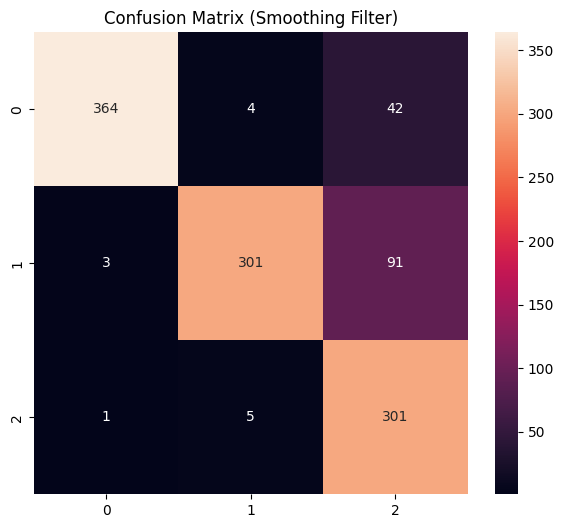

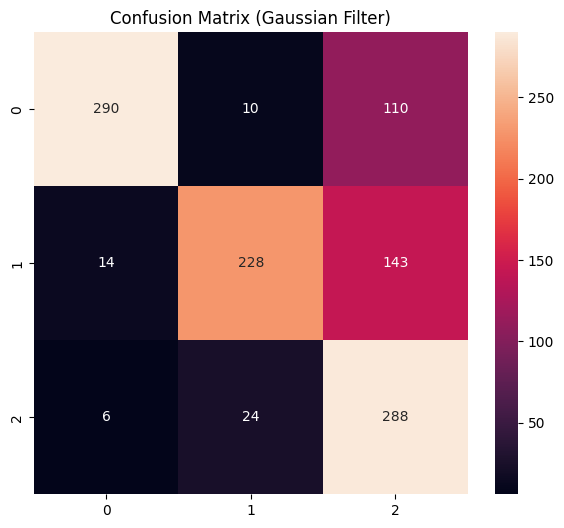

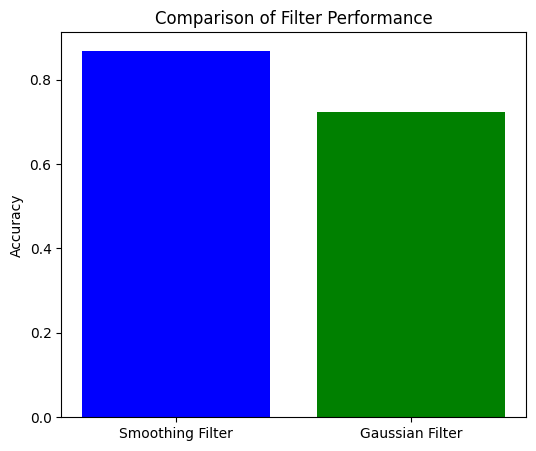


Classification Report (Smoothing Filter):
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       410
           1       0.97      0.76      0.85       395
           2       0.69      0.98      0.81       307

    accuracy                           0.87      1112
   macro avg       0.88      0.88      0.87      1112
weighted avg       0.90      0.87      0.87      1112


Classification Report (Gaussian Filter):
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       410
           1       0.87      0.59      0.70       385
           2       0.53      0.91      0.67       318

    accuracy                           0.72      1113
   macro avg       0.78      0.74      0.73      1113
weighted avg       0.80      0.72      0.73      1113



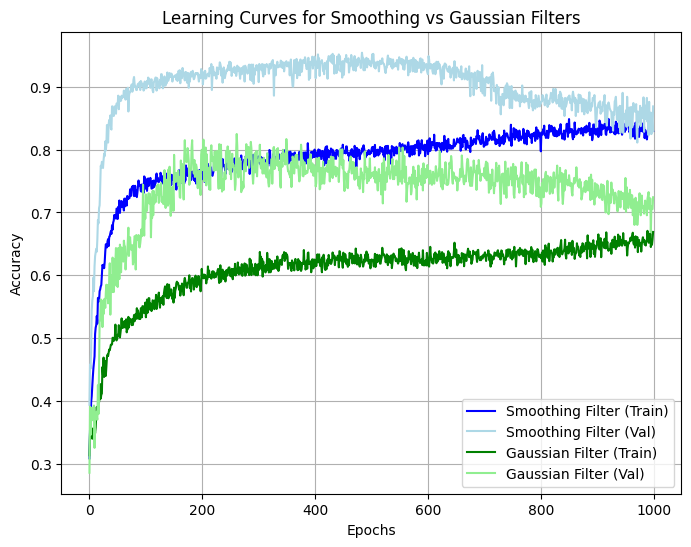

In [ ]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Import your preprocessing functions
from preprocessing import preprocess_keypoints  # Import preprocess_keypoints function

RANDOM_SEED = 42
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
NUM_CLASSES = 3

# Load dataset
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

# Apply preprocessing with smoothing filter
X_smoothing = preprocess_keypoints(X_dataset, filter_type='smoothing', normalize=True)
y_dataset_smoothing = y_dataset[:X_smoothing.shape[0]]  # Ensure the lengths match

# Apply preprocessing with Gaussian filter
X_gaussian = preprocess_keypoints(X_dataset, filter_type='gaussian', normalize=True)
y_dataset_gaussian = y_dataset[:X_gaussian.shape[0]]  # Ensure the lengths match

# Train-test split for smoothing filter
X_train_smoothing, X_test_smoothing, y_train_smoothing, y_test_smoothing = train_test_split(
    X_smoothing, y_dataset_smoothing, train_size=0.75, random_state=RANDOM_SEED
)

# Train-test split for Gaussian filter
X_train_gaussian, X_test_gaussian, y_train_gaussian, y_test_gaussian = train_test_split(
    X_gaussian, y_dataset_gaussian, train_size=0.75, random_state=RANDOM_SEED
)

# Model definition
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input((input_shape,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = build_model(X_train.shape[1])  # Define input shape based on data
    history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), verbose=1)
    _, accuracy = model.evaluate(X_test, y_test, verbose=1)
    return accuracy, model, history

# Train and evaluate models for both filters
print("Training and evaluating model with smoothing filter...")
accuracy_smoothing, model_smoothing, history_smoothing = train_and_evaluate(X_train_smoothing, X_test_smoothing, y_train_smoothing, y_test_smoothing)

print("Training and evaluating model with Gaussian filter...")
accuracy_gaussian, model_gaussian, history_gaussian = train_and_evaluate(X_train_gaussian, X_test_gaussian, y_train_gaussian, y_test_gaussian)

# Inference and confusion matrix for smoothing filter
Y_pred_smoothing = model_smoothing.predict(X_test_smoothing)
y_pred_smoothing = np.argmax(Y_pred_smoothing, axis=1)
cm_smoothing = confusion_matrix(y_test_smoothing, y_pred_smoothing)

# Inference and confusion matrix for Gaussian filter
Y_pred_gaussian = model_gaussian.predict(X_test_gaussian)
y_pred_gaussian = np.argmax(Y_pred_gaussian, axis=1)
cm_gaussian = confusion_matrix(y_test_gaussian, y_pred_gaussian)

# Plot confusion matrices for both filters
def plot_confusion_matrix(cmx_data, filter_name):
    labels = sorted(list(set(y_test_smoothing)))
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_test_smoothing)), 0)
    plt.title(f"Confusion Matrix ({filter_name} Filter)")
    plt.show()

# Plot confusion matrices for both filters
plot_confusion_matrix(cm_smoothing, 'Smoothing')
plot_confusion_matrix(cm_gaussian, 'Gaussian')

# Compare accuracies graphically
accuracies = [accuracy_smoothing, accuracy_gaussian]
filters = ['Smoothing Filter', 'Gaussian Filter']

# Plot the comparison of accuracies
plt.figure(figsize=(6, 5))
plt.bar(filters, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Filter Performance')
plt.show()

# Print classification reports for both filters
print("\nClassification Report (Smoothing Filter):")
print(classification_report(y_test_smoothing, y_pred_smoothing))

print("\nClassification Report (Gaussian Filter):")
print(classification_report(y_test_gaussian, y_pred_gaussian))

# Plot the learning curves for both filters
plt.figure(figsize=(8, 6))
plt.plot(history_smoothing.history['accuracy'], label='Smoothing Filter (Train)', color='blue')
plt.plot(history_smoothing.history['val_accuracy'], label='Smoothing Filter (Val)', color='lightblue')
plt.plot(history_gaussian.history['accuracy'], label='Gaussian Filter (Train)', color='green')
plt.plot(history_gaussian.history['val_accuracy'], label='Gaussian Filter (Val)', color='lightgreen')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves for Smoothing vs Gaussian Filters')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [ ]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [ ]:
NUM_CLASSES = 4

# Dataset reading

In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [ ]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
29/29 [==============================] - 2s 15ms/step - loss: 1.3853 - accuracy: 0.3360 - val_loss: 1.2779 - val_accuracy: 0.4244

Epoch 00001: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 2/1000
29/29 [==============================] - 0s 4ms/step - loss: 1.2943 - accuracy: 0.3780 - val_loss: 1.2151 - val_accuracy: 0.4703

Epoch 00002: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 3/1000
29/29 [==============================] - 0s 4ms/step - loss: 1.2524 - accuracy: 0.3749 - val_loss: 1.1472 - val_accuracy: 0.5572

Epoch 00003: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 4/1000
29/29 [==============================] - 0s 4ms/step - loss: 1.1989 - accuracy: 0.4251 - val_loss: 1.0682 - val_accuracy: 0.6374

Epoch 00004: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 5/1000
29/29 [==============================] - 0s 4ms/step - loss: 1.1363 - accuracy: 0.4733 - val_l

In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 2ms/step - loss: 0.2064 - accuracy: 0.9724


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[9.8105639e-01 1.8674158e-02 2.2328236e-04 4.6191799e-05]
0


# Confusion matrix

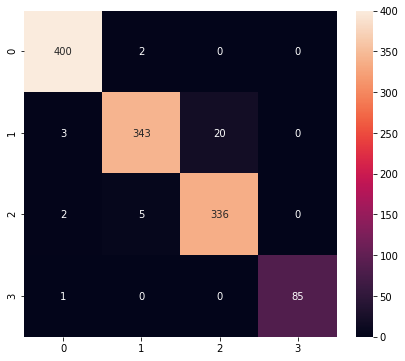

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       402
           1       0.98      0.94      0.96       366
           2       0.94      0.98      0.96       343
           3       1.00      0.99      0.99        86

    accuracy                           0.97      1197
   macro avg       0.98      0.98      0.98      1197
weighted avg       0.97      0.97      0.97      1197



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpe5yx255p/assets


6352

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 131 µs, sys: 17 µs, total: 148 µs
Wall time: 679 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.8105639e-01 1.8674169e-02 2.2328216e-04 4.6191799e-05]
0
